In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v01.parquet').astype(float)
female_df = female_df[keep_syllables]

In [48]:
# avarage per age or session
f_df= female_df.groupby(['age','uuid','mouse']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid','mouse'], inplace=True)
f_df = f_df.query('age<110')


avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

In [49]:
f_norm.reset_index()['age'].value_counts()

age
4      16
44     16
84     16
78     16
72     16
8      16
64     16
60     16
56     16
48     16
68     16
40     16
32     16
24     16
20     16
12     16
36     16
28     15
80     15
52     15
92     11
90     11
93      8
95      7
103     6
97      4
105     4
98      2
102     2
107     2
Name: count, dtype: int64

In [7]:
pc = PCA(n_components=3)
#pc.fit(m_data)
pcs_female = pc.fit_transform(f_norm)
pcm = pd.DataFrame(pcs_female)
pcm['psd'] = f_norm.index.get_level_values('age')

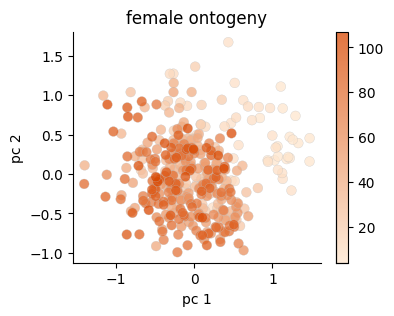

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
im = plt.scatter(x=pcm[0], y=pcm[1], 
                cmap=cmf,
                s=50,
                edgecolor='silver',
                c=pcm['psd'], 
                linewidth=0.25,
                #norm='log',
            alpha=0.75,
               )
cb=fig.colorbar(im,ax=ax)
sns.despine()
plt.title('female ontogeny')
plt.xlabel('pc 1')
plt.ylabel('pc 2')
c = PlotConfig()
#fig.savefig(c.dana_save_path / "simons"/ 'pca_male.pdf')

In [9]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'female_pca_no127.pdf')

In [10]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)

In [11]:
cumulative_variance_explained

array([0.15922511, 0.30493236, 0.42568977])

In [12]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcm[0], pcm['psd'])
print(cm)

-0.4074592662406439


/tmp/ipykernel_8318/3566511058.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


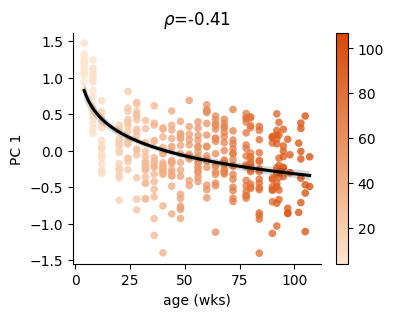

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=pcm['psd'], y=pcm[0], 
            s=30, 
            c=pcm['psd'], 
            edgecolor='none',
            linewidth=0.25,
            #norm='log',
            alpha=0.75,
            cmap=cmf)
ax = sns.regplot(data=pcm, x='psd', y=pcm[0], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='age (wks)', ylabel='PC 1')
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcm['psd'].min(), pcm['psd'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
#sm = plt.cm.ScalarMappable(cmap=cmm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'female_pca_corr_no127.pdf')

In [14]:
pcm['psd'].unique()

array([  4,   8,  12,  20,  24,  28,  32,  36,  40,  44,  48,  52,  56,
        60,  64,  68,  72,  78,  80,  84,  90,  92,  93,  95,  97,  98,
       102, 103, 105, 107])